In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

In [2]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def plot_learning_curve(loss_record,title=''):
    total_steps=len(loss_record['train'])
    x_1=range(total_steps)
    x_2=x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    plt.plot(x_1,loss_record['train'],c='tab:red',label='train')
    plt.plot(x_2,loss_record['dev'],c='tab:cyan',label='dev')
    plt.ylim(0.0,5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('learining curve of {}'.format(title))
    plt.show()

In [4]:
def plot_pred(dv_set,model,device,lim=35.,preds=None,targets=None):
    if preds is None or targets is None:
        model.eval()
        preds,targets=[],[]
        for x,y in dv_set:
            x,y=x.to(device),y.to(device)
            with torch.no_grad():
                pred=model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds=torch.cat(preds,dim=0).numpy()
        targets=torch.cat(targets,dim=0).numpy()
        
        figure(figsize=(5,5))
        plt.scatter(targets,preds,c='r',alpha=0.5)
        plt.plot([-0.2,lim],[-0.2,lim],c='b')
        plt.xlim(-0.2,lim)
        plt.ylim(-0.2,lim)
        plt.xlabel('ground truth value')
        plt.ylabel('predicted value')
        plt.title('Ground True v.s. Prediction')
        plt.show()
                

In [5]:
a=torch.tensor([[1,2,3],[2,3,4],[5,6,7]])
b=torch.tensor([[1,2,3],[2,3,5],[5,6,7]])
torch.cat((a,b),dim=1)

tensor([[1, 2, 3, 1, 2, 3],
        [2, 3, 4, 2, 3, 5],
        [5, 6, 7, 5, 6, 7]])

In [6]:
col_selected=[40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]

In [7]:
class COVID19Dataset(Dataset):
    def __init__(self, path, mode='train', target_only=False):
        self.mode = mode

        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        if not target_only:
#             feats = list(range(93))
            feats=list(range(40))+col_selected
        else:
            pass
        if mode == 'test':
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            target = data[:, -1]
            data = data[:, feats]

            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        self.data[:,40:]= \
        (self.data[:,40:]-self.data[:,40:].mean(dim=0,keepdim=True)) \
        / self.data[:,40:].std(dim=0,keepdim=True)

        self.dim = self.data.shape[1]
        print('Finish reading the {} set of COVID19 Dataset ({} samples found \
             ,each dim={})'.format(mode, len(self.data), self.dim))
    
    def __getitem__(self,index):
        if self.mode in ['train','dev']:
            return self.data[index],self.target[index]
        else:
            return self.data[index]
    
    def __len__(self):
        return len(self.data)

In [8]:
path=r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.train.csv'
covid19=COVID19Dataset(path,mode='train',target_only=False)

Finish reading the train set of COVID19 Dataset (2430 samples found              ,each dim=54)


In [9]:
dataloader=DataLoader(
    covid19,270,
    shuffle=('train'=='train'),drop_last=False,num_workers=4,pin_memory=True)

In [10]:
test_path=r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.test.csv'
covid19_test=COVID19Dataset(test_path,mode='test',target_only=False)

Finish reading the test set of COVID19 Dataset (893 samples found              ,each dim=54)


In [11]:
def prep_dataloader(path,mode,batch_size,n_jobs=0,target_only=False):
    dataset=COVID19Dataset(path,mode=mode,target_only=target_only)
    dataloader=DataLoader(
    dataset,batch_size,
    shuffle=(mode=='train'),drop_last=False,num_workers=n_jobs,pin_memory=True)
    return dataloader

In [144]:
def get_train_data():
    data=np.genfromtxt(r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.train.csv',
                      delimiter=',',skip_header=1)
    data=data[:,1:]
    labels=torch.tensor(data[:,-1],dtype=torch.float32)
    data[:,40:]=(data[:,40:]-data[:,40:].mean(axis=0)) / (data[:,40:].std(axis=0))
    features=torch.tensor(data[:,:-1],dtype=torch.float32)
    return features,labels

In [145]:
features,labels=get_train_data()
features.shape

torch.Size([2700, 93])

In [146]:
labels.shape

torch.Size([2700])

In [58]:
data_iter=torch.utils.data.DataLoader(
torch.utils.data.TensorDataset(features,labels),
    batch_size=270,shuffle=True)

In [147]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, 64), 
                                 nn.ReLU(),
                                 nn.Linear(64, 1),
                                )
        self.criterion = nn.MSELoss(reduce='mean')
    
    def forward(self,x):
        return self.net(x).squeeze(1)
    
    def cal_loss(self,pred,target):
        return self.criterion(pred,target)

In [164]:
from sklearn.model_selection import train_test_split

In [165]:
def train(features,labels, model, config, device):
    n_epochs = config['n_epochs']
    optimizer = getattr(torch.optim,
                        config['optimizer'])(model.parameters(),
                                             **config['optim_hparas'])
    
    batch_size=config['batch_size']
    x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.1,random_state =13,shuffle=True)
    
    data_iter=torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train,y_train),batch_size=batch_size,
    shuffle=True)

    
    dev_data=torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test,y_test),batch_size=100,
    shuffle=True)

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for x, y in data_iter:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            mse_loss = model.cal_loss(pred, y)
            mse_loss.backward()
            optimizer.step()
            loss_record['train'].append(mse_loss.detach().cpu().item())
        dev_mse = dev(dev_data, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse
            print('save model (epoch={:4d},,loss={:.4})'.format(
                epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            break
    print('finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [166]:
def dev(dev_set,model,device):
    model.eval()
    total_loss=0
    for x,y in dev_set:
        x,y =x.to(device),y.to(device)
        with torch.no_grad():
            pred=model(x)
            mse_loss=model.cal_loss(pred,y)
        total_loss +=mse_loss.detach().cpu().item() *len(x)
    total_loss=total_loss / len(dev_set.dataset)
    return total_loss
        

In [167]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [168]:
device=get_device()
os.makedirs(r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\models',
           exist_ok=True)
target_only=False

config={
    'n_epochs':3000,
    'batch_size':270,
    'optimizer':'SGD',
    'optim_hparas':{
        'lr':0.002,
        'momentum': 0.7
    },
    'early_stop':100,
    'save_path':r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\models\model',
}

In [169]:
tr_path=r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.train.csv'
tt_path=r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.test.csv'

In [170]:
tr_set=prep_dataloader(tr_path,'train',config['batch_size'],target_only=target_only)
dv_set=prep_dataloader(tr_path,'dev',config['batch_size'],target_only=target_only)
tt_set=prep_dataloader(tt_path,'test',config['batch_size'],target_only=target_only)

Finish reading the train set of COVID19 Dataset (2430 samples found              ,each dim=54)
Finish reading the dev set of COVID19 Dataset (270 samples found              ,each dim=54)
Finish reading the test set of COVID19 Dataset (893 samples found              ,each dim=54)


In [171]:
model = NeuralNet(features.shape[1]).to(device) 

D:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [172]:
model_loss, model_loss_record = train(features, labels, model, config, device)

TypeError: take(): argument 'index' (position 1) must be Tensor, not numpy.ndarray

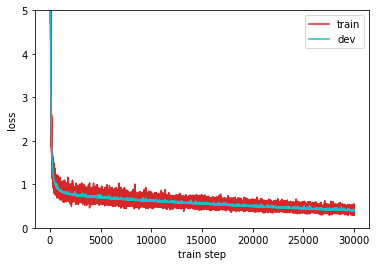

In [156]:
x_1=range(len(model_loss_record['train']))
x_2=x_1[::len(model_loss_record['train']) // len(model_loss_record['dev'])]
plt.plot(x_1,model_loss_record['train'],c='tab:red',label='train')
plt.plot(x_2,model_loss_record['dev'],c='tab:cyan',label='dev')
plt.ylim(0.0,5.)
plt.xlabel('train step')
plt.ylabel('loss')
plt.legend()
plt.show()

In [157]:
def get_test_data():
    data=np.genfromtxt(r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.test.csv',
                      delimiter=',',skip_header=1)
    data=data[:,1:]
    data[:,40:]=(data[:,40:]-data[:,40:].mean(axis=0)) / (data[:,40:].std(axis=0))
    features=torch.tensor(data,dtype=torch.float32)
    return features

In [158]:
test_feats=get_test_data()
# test_feats.shape()

In [159]:
test_feats.size()

torch.Size([893, 93])

In [160]:
model.eval()                                # set model to evalutation mode
preds = []                          # iterate through the dataloader
# x = x.to(device)                        # move data to device (cpu/cuda)
with torch.no_grad():                   # disable gradient calculation
    pred = model(test_feats)                     # forward pass (compute output)
    preds.append(pred.detach().cpu())   # collect prediction
preds = torch.cat(preds, dim=0).numpy()  

In [161]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []                          # iterate through the dataloader
    with torch.no_grad():                   # disable gradient calculation
        pred = model(test_feats)                     # forward pass (compute output)
        preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [162]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

In [163]:
preds = test(test_feats, model, device)  # predict COVID-19 cases with your model
save_pred(preds, r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\pred222.csv')  

Saving results to F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\pred222.csv
